
# Projet 2

In [1]:
# import des modules usuels
import numpy as np
import pandas as pd

# options d'affichage
pd.set_option("display.min_rows", 16)

In [2]:
# chargement et traitement des données
geo = pd.read_csv("correspondance-code-insee-code-postal.csv",
                   sep=';',
                   usecols=range(11),
                   index_col="Code INSEE")
geo = geo.sort_index()
geo[['Latitude', 'Longitude']] = geo["geo_point_2d"].str.extract("(.*), (.*)").astype(float)
geo.head()

,Code Postal,Commune,Département,Région,Statut,Altitude Moyenne,Superficie,Population,geo_point_2d,geo_shape,Latitude,Longitude
Code INSEE,,,,,,,,,,,,
01001,01400,L'ABERGEMENT-CLEMENCIAT,AIN,RHONE-ALPES,Commune simple,242.0,1565.0,0.8,"46.1534255214, 4.92611354223","{""type"": ""Polygon"", ""coordinates"": [[[4.926273...",46.153426,4.926114
01002,01640,L'ABERGEMENT-DE-VAREY,AIN,RHONE-ALPES,Commune simple,483.0,912.0,0.2,"46.0091878776, 5.42801696363","{""type"": ""Polygon"", ""coordinates"": [[[5.430089...",46.009188,5.428017
01004,01500,AMBERIEU-EN-BUGEY,AIN,RHONE-ALPES,Chef-lieu canton,379.0,2448.0,13.4,"45.9608475114, 5.3729257777","{""type"": ""Polygon"", ""coordinates"": [[[5.386190...",45.960848,5.372926
01005,01330,AMBERIEUX-EN-DOMBES,AIN,RHONE-ALPES,Commune simple,290.0,1605.0,1.6,"45.9961799872, 4.91227250796","{""type"": ""Polygon"", ""coordinates"": [[[4.895580...",45.996180,4.912273
01006,01300,AMBLEON,AIN,RHONE-ALPES,Commune simple,589.0,602.0,0.1,"45.7494989044, 5.59432017366","{""type"": ""Polygon"", ""coordinates"": [[[5.614854...",45.749499,5.594320


**Projet maison n° 1**

- Ajoutez une colonne 'CP Ville' avec le Code postal + un espace + et le nom de la Ville.
- Ecrivez une fonction qui détermine la commune la plus proche d'un point à partir de sa latitude et sa longitude.
- Ajoutez une fonction de conversion pour pouvoir utiliser la première fonction avec un GPS (degrés, minutes, secondes).

In [3]:
# Ajoutez une colonne 'CP Ville' avec le Code postal + un espace + et le nom de la Ville.
geo["CP Ville"] = geo["Code Postal"] + " " + geo["Commune"]


def haversine(lat1, lon1, lat2, lon2, to_radians=True, radius=6371):
    """
    Fonction qui calcule la distance de deux points sur une sphere.
    Le radius par défaut est celui de la Terre (en km).
    """
    if to_radians:
        lat1, lon1, lat2, lon2 = np.radians([lat1, lon1, lat2, lon2])

    a = np.sin((lat2 - lat1) / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin((lon2 - lon1) / 2.0) ** 2

    return radius * 2 * np.arcsin(np.sqrt(a))

 
# fonction recherche de ville
def ville(lat, long):
    lat = np.full(len(geo), fill_value=lat)
    long = np.full(len(geo), fill_value=long)
    all_dists = haversine(geo["Latitude"], geo["Longitude"], lat, long)
    min_idx = np.argmin(all_dists)
    return geo["Commune"][min_idx]   

In [4]:
# conversion degrés, minutes, secondes => décimal
def dms2dec(deg, mn, sec):
    return deg + mn / 60 + sec / 3600

In [5]:
# on applique la fonction à une coordonnée tirée au hasard
# init du random
np.random.seed(0)

a, b = 41.5, 51.1  # latitude min et max de la France métropolitaine
lat = (b - a) * np.random.random() + a
a, b = -5.1, 9.5  # longitude min et max de la France métropolitaine
long = (b - a) * np.random.random() + a

ville(lat, long)

'BOSJEAN'

In [6]:
# à partir de coordonnées GPS précises
ville(dms2dec(48, 42, 52), dms2dec(2, 14, 45))

'PALAISEAU'

**Projet maison n° 2**

La colonne "geo_shape" comporte des chaines de catactères au format JSON. Elles représentent les formes géométriques des communes qui sont soit des polygones soit composées de plusieurs polygones.

- Utiliser la librairie Python json pour parser la colonne "geo_shape".
- Donner le décompte des valeurs accédées avec la clé "type".
- Donner le décompte des longueurs des listes accédées avec la clé "coordinates".
- Quelle commune est la plus complexe géométriquement ?
- Quelle commune est la seconde la plus complexe géométriquement ?
- Quelles sont les villes qui sont de type "Polygon" mais dont la longueur des listes accédées avec la clé "coordinates" vaut 2 ?
- Pour ces villes vérifier que le premier polygone contient bien le second (enclave). NB : installer la librairie shapely, utiliser la classe Polygon de shapely.geometry. Sur Windows shapely peut nécessiter d'installer la dll "geos_c.dll" dans le répertoire "Library/bin" de votre environnement Python.

In [7]:
import json

# Donner le décompte des valeurs accédées avec la clé "type".
def get_poly_type(row):
    """
    Fonction qui parse une entrée json et renvoie le contenu de la clé "type"
    """
    json_dict = json.loads(row)
    return json_dict["type"]

geo["poly_type"] = geo['geo_shape'].apply(get_poly_type)
geo["poly_type"].value_counts()

Polygon         36670
MultiPolygon       72
Name: poly_type, dtype: int64

In [8]:
def get_poly_len(row, nested=False):
    """
    Fonction qui parse une entrée json et renvoie la longueur de la liste contenue
    dans la clé 'coordinates' ou la longueur totale des listes imbriquées.
    """
    total_len = 0
    json_dict = json.loads(row)
    first_len = len(json_dict["coordinates"])
    
    if not nested:
        return first_len
    else:
        for i in range(first_len):
            total_len += len(json_dict["coordinates"][i])
        return total_len

# longueur des listes de premier niveau
geo["poly_length"] = geo["geo_shape"].apply(get_poly_len, args=[False])
geo["poly_length"].value_counts()

1    36660
2       80
3        1
4        1
Name: poly_length, dtype: int64

In [9]:
# longueur des listes de second niveau
geo["poly_length2"] = geo["geo_shape"].apply(get_poly_len, args=[True])
geo["poly_length2"].value_counts()

11     3396
12     3336
10     3186
13     3023
9      2822
14     2678
15     2424
8      2174
       ... 
152       1
86        1
3         1
53        1
95        1
62        1
80        1
122       1
Name: poly_length2, Length: 81, dtype: int64

In [10]:
# Quelle commune est la plus complexe géométriquement ?
# niveau 1
print("Commune: ", geo["Commune"][geo["poly_length"].argmax()])
print("longueur de la liste de premier niveau (nbre de polygones): ", geo["poly_length"].max())
# niveau 2
print("Commune: ", geo["Commune"][geo["poly_length2"].argmax()])
print("longueur des listes de deuxieme niveau (nbre de cotés des polygones): ", geo["poly_length2"].max())

Commune:  HYERES
longueur de la liste de premier niveau (nbre de polygones):  4
Commune:  MARIPASOULA
longueur des listes de deuxieme niveau (nbre de cotés des polygones):  486


In [11]:
# Quelle commune est la seconde la plus complexe géométriquement ?

# niveau 1
top2_val = sorted(geo["poly_length"].unique(), reverse=True)[1]
mask = geo["poly_length"] == top2_val
top2_ville = geo["Commune"][mask][0]
print(f"2ème ville la plus complexe (1er niveau): {top2_ville} ({top2_val} polygones)")

# niveau 2
top2_val = sorted(geo["poly_length2"].unique(), reverse=True)[1]
mask = geo["poly_length2"] == top2_val
top2_ville = geo["Commune"][mask][0]
print(f"2ème ville la plus complexe (2ème niveau): {top2_ville} ({top2_val} cotés)")

2ème ville la plus complexe (1er niveau): VAL-DE-REUIL (3 polygones)
2ème ville la plus complexe (2ème niveau): REGINA (392 cotés)


In [12]:
# Quelles sont les villes qui sont de type "Polygon" mais dont la longueur des listes accédées avec la clé "coordinates" vaut 2 ?
mask = (geo["poly_type"] == "Polygon") & (geo["poly_length"] == 2)
comms2 = geo[mask]["Commune"]
print(comms2)

Code INSEE
02232               COYOLLES
05052               EYGLIERS
09042    LA BASTIDE-DE-SEROU
22209              PLOUBALAY
2A272                SARTENE
2B049              CALENZANA
48080               LANGOGNE
67486              SUNDHOUSE
68078              EGUISHEIM
71028            BEAUVERNOIS
Name: Commune, dtype: object


In [13]:
# Pour ces villes vérifier que le premier polygone contient bien le second (enclave). 
# NB : installer la librairie shapely, utiliser la classe Polygon de shapely.geometry.
from shapely import geometry as gm

def get_polygons(row):
    json_dict = json.loads(row)
    poly_fig = gm.shape(json_dict)
    return poly_fig

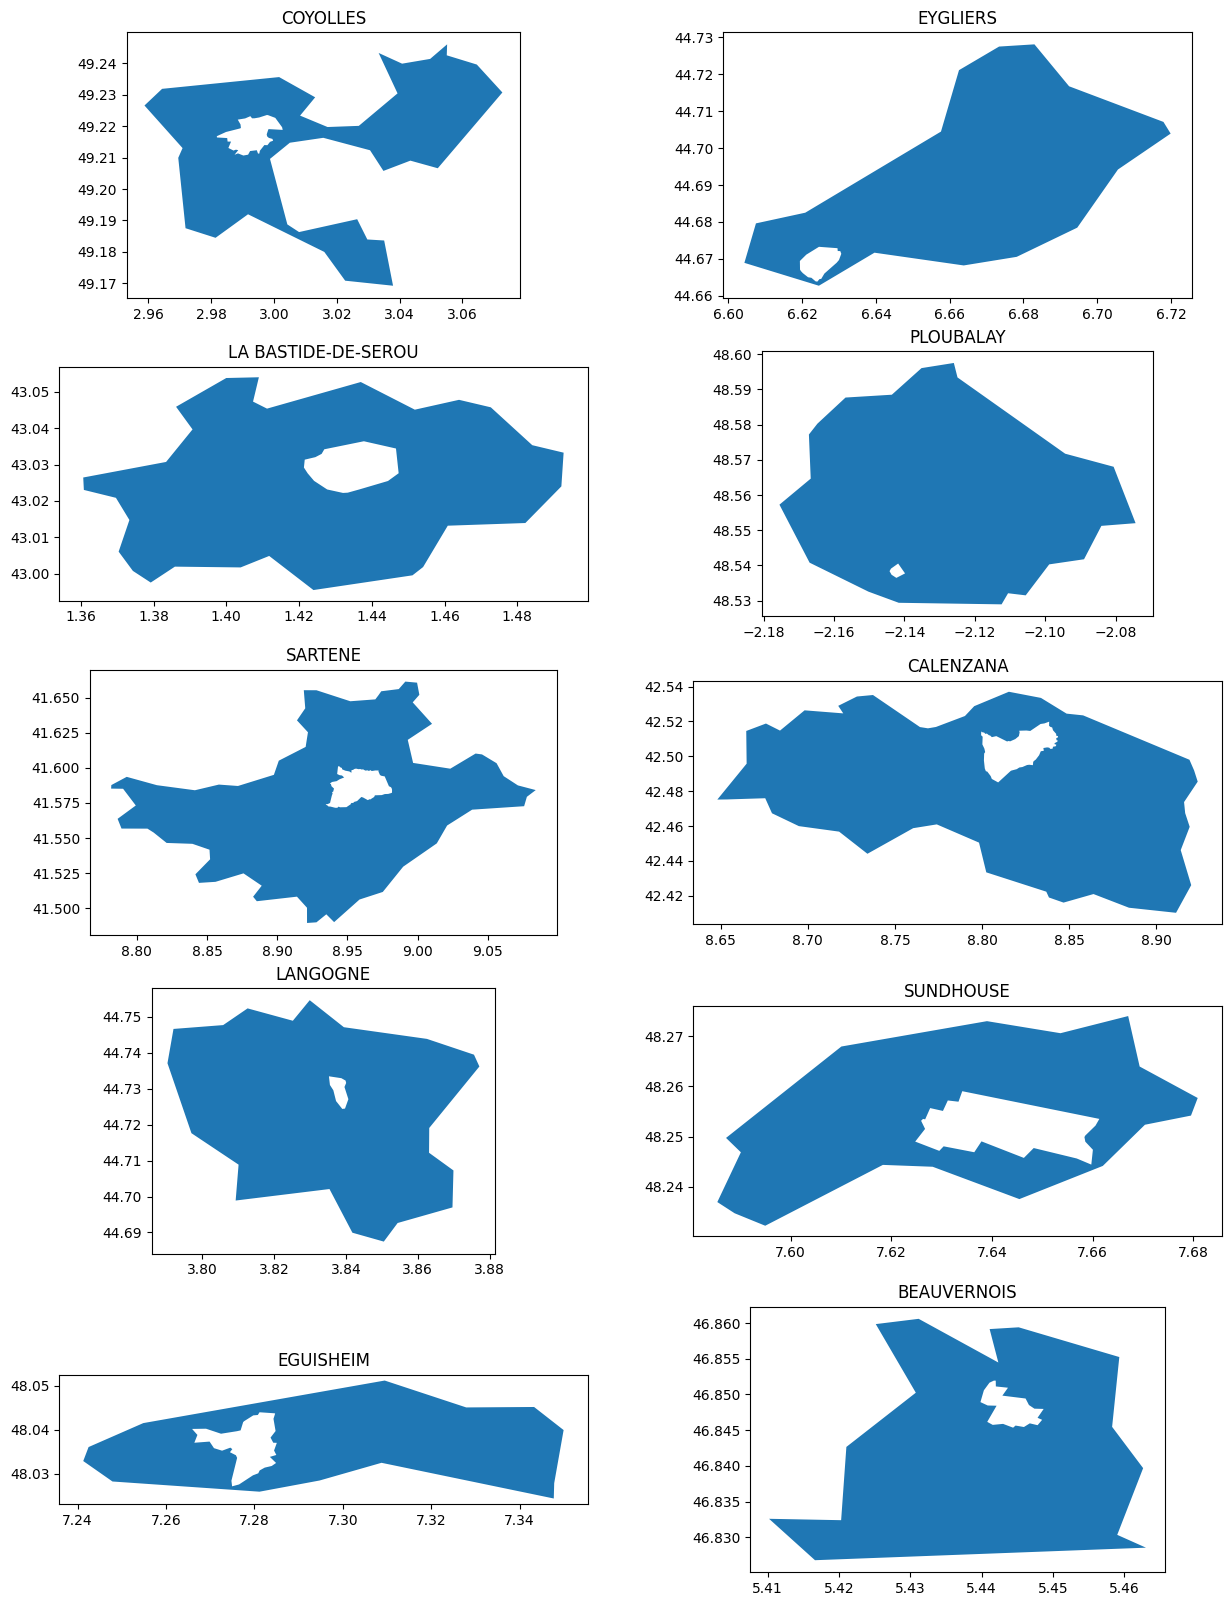

In [14]:
import matplotlib.pyplot as plt
import geopandas as gpd

fig, axes = plt.subplots(5,2, figsize=(15,20))

for k, idx in enumerate(comms2.index):
    i = k // 2
    j = k % 2
    city_shape = geo["geo_shape"][idx]
    city = geo["Commune"][idx]
    fig_shape = get_polygons(city_shape)
    axes[i, j].set_title(city)
    p = gpd.GeoSeries(fig_shape)
    p.plot(ax=axes[i,j])

plt.show()